In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
import anndata as ad
import matplotlib.pyplot as plt
import squidpy as sq
from shapely import wkt
from shapely.geometry import Polygon
import tifffile

import os
import warnings

# Suppress all future warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

### Solving directories

In [18]:
print("Previous working directory:", os.getcwd())

if 'notebooks' in os.getcwd():
    os.chdir("..")

target_path = os.path.join("data", "healthy_skin")

if os.path.exists(target_path) and os.path.isdir(target_path):
    os.chdir(target_path)
    print("Current working directory:", os.getcwd())
else:
    print(f"Error: The directory '{target_path}' does not exist.")


Previous working directory: c:\Users\sevco\Documents\dimplomka\gitRepo\Keratoacanthoma_spatial_transcriptomics\data\healthy_skin
Error: The directory 'data\healthy_skin' does not exist.


### Load Data

In [19]:
# 1. Load cell metadata
cells = pd.read_parquet("raw/cells.parquet")

In [14]:
# 2. Load transcript coordinates (spot-level)
transcripts = pd.read_parquet("raw/transcripts.parquet")

In [16]:
# 3. Load gene × cell matrix
adata = sc.read_10x_h5("raw/cell_feature_matrix.h5")
adata.var_names_make_unique()

# Add cell metadata to AnnData
adata.obs = adata.obs.join(cells.set_index("cell_id"))
adata

AnnData object with n_obs × n_vars = 68476 × 377
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'

In [17]:
# 4. Load cell boundaries (if needed for plotting)
cell_boundaries = pd.read_parquet("raw/cell_boundaries.parquet")
print(cell_boundaries.columns)
cell_boundaries.head()

# Group all vertex points per cell
polygons = (
    cell_boundaries
    .groupby("cell_id")[["vertex_x", "vertex_y"]]
    .apply(lambda pts: Polygon(zip(pts.vertex_x, pts.vertex_y)))
)

# Merge back into DataFrame
cell_boundaries = pd.DataFrame({"cell_id": polygons.index, "geometry": polygons.values})

Index(['cell_id', 'vertex_x', 'vertex_y'], dtype='object')


In [ ]:
# 5. Load morphology image
# morph_img = tifffile.imread("morphology.ome.tif")
# print(morph_img.shape)  # usually (channels, height, width) or (height, width, channels)

# Zarr file format

# QC anf filtering

In [21]:
adata.obs

,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area
aaadndhi-1,3034.833252,868.759277,0,0,0,0,0,0,681.136900,20.862188
aaadpami-1,3219.912842,855.015137,2,0,0,0,0,2,191.191569,8.624844
aaaegohp-1,3138.709229,852.792175,8,0,0,0,0,8,1027.756287,21.358907
aaaemelg-1,3221.546875,838.122253,7,0,0,0,0,7,901.228470,56.761408
aaafckig-1,3234.870850,856.646606,0,0,0,0,0,0,377.415951,8.399063
...,...,...,...,...,...,...,...,...,...,...
oikniknf-1,5900.959473,8592.821289,26,0,0,0,0,26,41.408283,11.198750
oiknmbcj-1,5930.239746,8589.894531,72,0,0,0,0,72,54.413283,24.429532
oikobdim-1,5919.693359,8592.031250,58,0,0,0,0,58,71.301721,34.138126
oikpcmpe-1,5906.821777,8595.217773,41,0,0,0,0,41,77.939690,25.377813


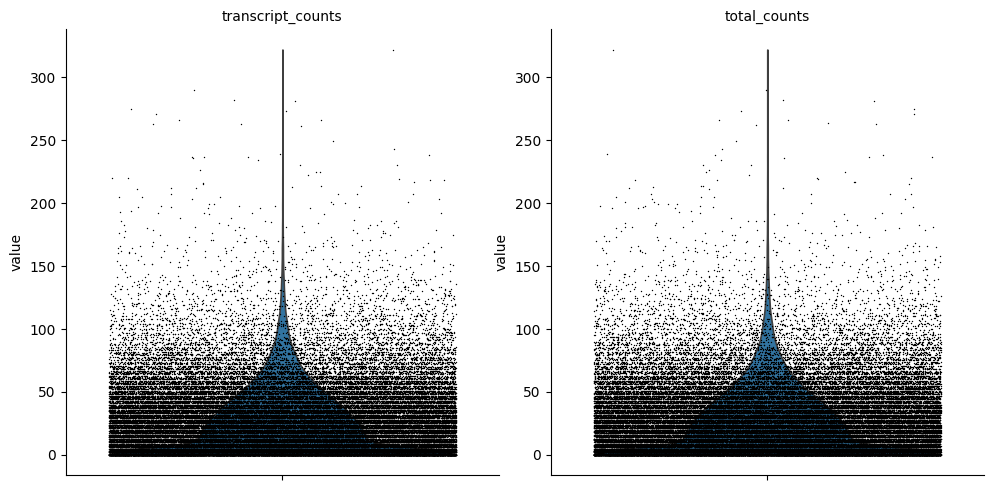

In [22]:
sc.pl.violin(
    adata,
    ["transcript_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
)

In [23]:
adata.obs.columns

Index(['x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts',
       'control_codeword_counts', 'unassigned_codeword_counts',
       'deprecated_codeword_counts', 'total_counts', 'cell_area',
       'nucleus_area'],
      dtype='object')

In [25]:
# 6. QC filtering example
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=3)